# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code. As you work through this notebook and find you need to import a package, make sure to add the import up here.

## Preparing the Notbook

In order to get started with Jupyter Notebook on Google Colab we have to configure and install some dependencies.

In [0]:
# Unzip the data folder
#!unzip data.zip
#!rm -R data.zip
from google.colab import drive
drive.mount('/content/drive')


In [0]:
# Install pytorch from http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
import torch

tcmalloc: large alloc 1073750016 bytes == 0x58bd0000 @  0x7f5e0e9342a4 0x591a07 0x5b5d56 0x502e9a 0x506859 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x504c28 0x502540 0x502f3d 0x507641


In [0]:
# workaround for PIL Image because of issuse
from PIL import Image
def register_extension(id, extension): Image.EXTENSION[extension.lower()] = id.upper()
Image.register_extension = register_extension
def register_extensions(id, extensions): 
  for extension in extensions: register_extension(id, extension)
Image.register_extensions = register_extensions

## Import the libraries

In [0]:
# Imports here
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms

import torch.nn.functional as F

import matplotlib.pyplot as plt
import time
import os
import copy
plt.ion()

## Test for CUDA

Since these are larger (32x32x3) images, it may prove useful to speed up your training time by using a GPU. CUDA is a parallel computing platform and CUDA Tensors are the same as typical Tensors, only they utilize GPU's for computation.

In [0]:
# Check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
  print('CUDA is not available. Training on CPU ...')
else:
  print('CUDA is available! Training on GPU ...')

CUDA is available! Training on GPU ...


## Load the data

Here you'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). You can [download the data here](https://s3.amazonaws.com/content.udacity-data.com/courses/nd188/flower_data.zip). The dataset is split into two parts, training and validation. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. If you use a pre-trained network, you'll also need to make sure the input data is resized to 224x224 pixels as required by the networks.

The validation set is used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks available from `torchvision` were trained on the ImageNet dataset where each color channel was normalized separately. For both sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.

In [0]:
# data
path_dir = '/content/drive/My Drive/Colab Notebooks/udacity/'
data_dir = path_dir + 'flower_data'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/val'

# configurations
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

In [0]:
BATCH_SIZE = 32

WORKERS = 1

EPOCHS = 20

BASE_LR = 0.001

# number of epochs after which the Learning rate is decayed exponentially.
EPOCH_DECAY = 30 

# factor by which the learning rate is reduced.
DECAY_WEIGHT = 0.1 

NUM_CLASSES = 2 

# SETTINGS FOR DISPLAYING ON TENSORBOARD
#USE_TENSORBOARD = 0 #if you want to use tensorboard set this to 1.
#TENSORBOARD_SERVER = "YOUR TENSORBOARD SERVER ADDRESS HERE" # If you set.
#EXP_NAME = "fine_tuning_experiment" # if using tensorboard, enter name of experiment you want it to be displayed as.

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


1    12  18  23  29  34  4   45  50  56  61  67  72  78  83  89  94
10   13  19  24  3   35  40  46  51  57  62  68  73  79  84  9	 95
100  14  2   25  30  36  41  47  52  58  63  69  74  8	 85  90  96
101  15  20  26  31  37  42  48  53  59  64  7	 75  80  86  91  97
102  16  21  27  32  38  43  49  54  6	 65  70  76  81  87  92  98
11   17  22  28  33  39  44  5	 55  60  66  71  77  82  88  93  99


In [0]:
# Defining transforms for the training and validation sets
# Data augmentation and normalization for training
# Just normalization for validation

data_transforms = {
    'train' : transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'val' : transforms.Compose([
        transforms.Resize(256),
        transforms.RandomResizedCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])
}

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), 
                                          data_transforms[x]) 
                  for x in ['train', 'val']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=BATCH_SIZE,
                                             shuffle=True) 
               for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [0]:
import json

with open(path_dir + 'cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

tensor([ 85,  54,  66,  77, 101,  73,  83,  97,   3,  82,  63,  89,  49,  38,
         15,  90,   2,  78,  81, 100,  30,  54,  80,  69,  99,  78,  81,  89,
        100,  33,  86,  57])


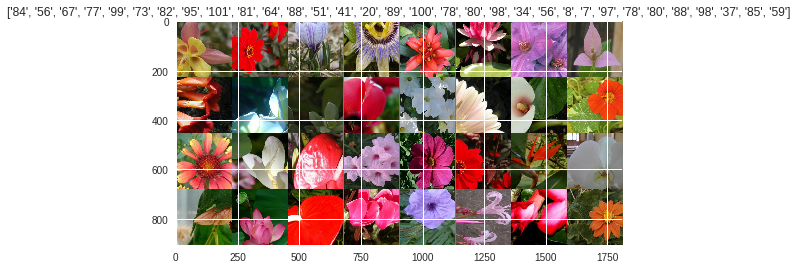

In [0]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))
print(classes)
# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. If you want to talk through it with someone, chat with your fellow students! You can also ask questions on the forums or join the instructors in office hours.

Refer to [the rubric](https://review.udacity.com/#!/rubrics/1663/view) for guidance on successfully completing this section. Things you'll need to do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (If you need a starting point, the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right. Make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. Save those hyperparameters to use as default values in the next part of the project.

We can load in a model such as ResNet. Let's print out the model architecture so we can see what's going on.

## Model Training and Validation Code

The `train_model` function handles the training and validation of a given model. As input, it takes a PyTorch model, a dictionary of dataloaders, a loss function, an optimizer, a specified number of epochs to train and validate for, and a boolean flag for when the model is an Inception model. The is_inception flag is used to accomodate the Inception v3 model, as that architecture uses an auxiliary output and the overall model loss respects both the auxiliary output and the final output, as described [here](https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958). The function trains for the specified number of epochs and after each epoch runs a full validation step. It also keeps track of the best performing model (in terms of validation accuracy), and at the end of training returns the best performing model. After each epoch, the training and validation accuracies are printed.

In [0]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'validation']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            running_f1 = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
                running_f1 += f1_score(labels.cpu().data, preds.cpu().data > 0.5, average="weighted")
                
            data_size_batch =  dataset_sizes[phase] / 32
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            epoch_f1 = running_f1 / data_size_batch

            #print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            print('{} Loss: {:.4f} F1: {:.4f}'.format(
                phase, epoch_loss, epoch_f1))
            # deep copy the model
            if phase == 'validation' and epoch_f1 > best_acc:
                best_acc = epoch_f1
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

### Visiualizing the model predicitons

Generic function to display predicitons for a view images

In [0]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

## Train the model


In [0]:
model = models.resnet152(pretrained=True)
# Freeze parameters so we don't backprop through them
for param in model.parameters():
    param.requires_grad = False
    
num_features = model.fc.in_features

from collections import OrderedDict
classifier = nn.Sequential(OrderedDict([
                              ('fc1', nn.Linear(num_features, 512)),
                              ('relu', nn.ReLU()),
                              ('hidden', nn.Linear(512, 256)),
                              ('relu2', nn.ReLU()),
                              ('fc2', nn.Linear(256, 102)),
                              ('output', nn.LogSoftmax(dim=1)),
                              ]))
model.fc = classifier
model = model.to(device)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.torch/models/resnet18-5c106cde.pth
100%|██████████| 46827520/46827520 [00:00<00:00, 61560100.34it/s]


Epoch 0/9
----------


In [0]:
visualize_model(model)


In [0]:
# Number of epochs to train for
#num_epochs = 10
#learning_rate = 0.001

#criterion = nn.NLLLoss()

#optimizer = optim.SGD(model.fc.parameters(), lr=learning_rate)

#exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

#model = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=num_epochs)
num_epochs = 20

criterion = nn.NLLLoss()

optimizer = optim.Adam(model.fc.parameters(), lr=BASE_LR)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

model = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=num_epochs)

## Save the checkpoint

Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

In [0]:
# TODO: Save the checkpoint 
print("Our model: \n\n", model, '\n')
print("The state dict keys: \n\n", model.state_dict().keys())

The simplest thing to do is simply save the state dict with `torch.save`. For example, we can save it to a file `'checkpoint.pth'`.

In [0]:
torch.save(model.state_dict(), path_dir + 'checkpoint.pth')

Then we can load the satet dict with `torch.load`

In [0]:
state_dict = torch.load(path_dir + 'checkpoint.pth')
print(state_dict.keys())

And to load the state dict in to the network, you do `model.load_state_dict(state_dict)`.

In [0]:
model.load_state_dict(state_dict)

## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [0]:
# TODO: Write a function that loads a checkpoint and rebuilds the model

# Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First you'll need to handle processing the input image such that it can be used in your network. 

## Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [0]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    
    # TODO: Process a PIL image for use in a PyTorch model

To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

In [0]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

## Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [0]:
def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    
    # TODO: Implement the code to predict the class from an image file

## Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the validation accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='assets/inference_example.png' width=300px>

You can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

In [0]:
# TODO: Display an image along with the top 5 classes